# Student Performance Dataset from https://archive.ics.uci.edu/dataset/320/student+performance

## Imports + Getting Data

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression as sklearn_linreg
from diffprivlib.models import LinearRegression as dp_linreg
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

In [7]:
math_df = pd.read_csv("../../Data/student-mat.csv", sep=";")
math_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## Pre-Processing

In [8]:
# OHE Categorical Features
math_df = pd.get_dummies(math_df, columns=math_df.columns.drop(["absences", "age", "G1", "G2", "G3"]), drop_first=True)

In [9]:
# Split into Training and Testing Set
X = math_df.drop("G3", axis=1)
y = math_df[["G3"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
# Normalize Dataset
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Feature Selection

### [Not Chosen] Testing PCA

In [7]:
# Perform PCA on the Training Dataset
pca = PCA(n_components=len(X_train.columns)).fit(X_train_scaled)
pca_explained_var = pca.explained_variance_ratio_
pca_cum_explained_var = np.cumsum(pca_explained_var)

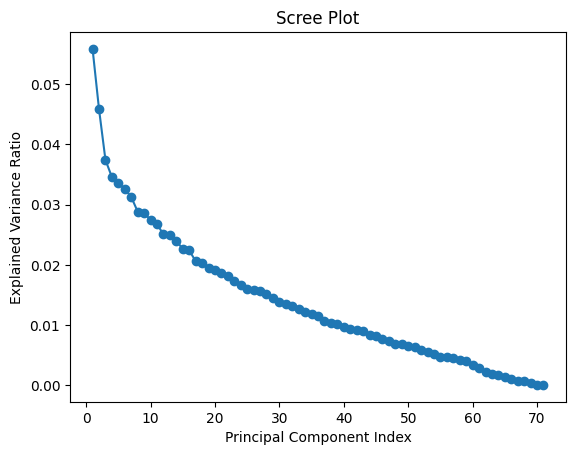

In [8]:
pc_vals = np.arange(pca.n_components_) + 1
plt.plot(pc_vals, pca.explained_variance_ratio_, 'o-');
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot");

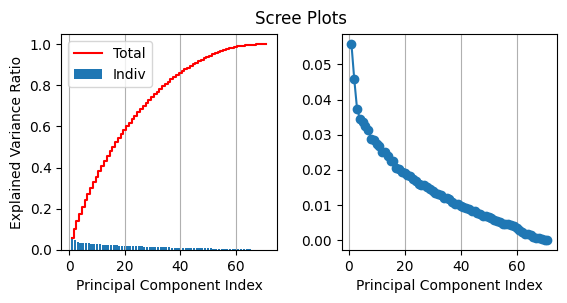

In [9]:
# Visualize Explained Variance using Scree Plots
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(range(1, pca.n_components_ + 1), pca_explained_var, align="center", label="Indiv")
ax1.step(range(1, pca.n_components_ + 1), pca_cum_explained_var, where="mid", label="Total", color="red")
ax2.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 'o-')
ax1.set(xlabel="Principal Component Index")
ax2.set(xlabel="Principal Component Index")
ax1.set(ylabel="Explained Variance Ratio")
fig.suptitle("Scree Plots", y=0.77)
ax1.grid(axis="x")
ax2.grid(axis="x")
ax1.legend(loc="upper left")
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
plt.subplots_adjust(wspace=0.3);

### [Not Chosen] Testing SelectKBest

In [16]:
def getKBestFeatures(X_train_scaled, X_test_scaled, y_train, k):
    selector = SelectKBest(score_func=mutual_info_regression, k=k)
    X_train_topk = selector.fit_transform(X_train_scaled, y_train.values.ravel())
    X_test_topk = selector.transform(X_test_scaled)
    return X_train_topk, X_test_topk

X_train_top5, X_test_top5 = getKBestFeatures(X_train_scaled, X_test_scaled, y_train, 10)

### [Chosen] Testing Highest Coefficientss From Baseline Linear Regression

In [13]:
min_bounds_X = [-3 for _ in range(X_train_scaled.shape[1])]
max_bounds_X = [3 for _ in range(X_train_scaled.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Baseline Linear Regression
# Create "baseline" Linear Regression model using DP version with infinite epsilon
lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0, 20)).fit(X_train_scaled, y_train)  
lr_scores = cross_val_score(lr, X_test_scaled, y_test, cv=5, scoring='neg_mean_squared_error')

# Get RMSE
lr_err = np.mean(np.power(np.abs(lr_scores), 0.5))

print("Regular RMSE:", lr_err)

def getKBestFeatures(X_train, X_test, baseline_coefs, k):
    abs_baseline_coefs = np.absolute(baseline_coefs[0])
    ind = np.argpartition(abs_baseline_coefs, -k)[-k:]
    X_train_top_k, X_test_top_k = X_train[:,ind], X_test[:,ind]
    scaler = preprocessing.StandardScaler().fit(X_train_top_k)
    X_train_scaled = scaler.transform(X_train_top_k)
    X_test_scaled = scaler.transform(X_test_top_k)
    return X_train_scaled, X_test_scaled

Regular RMSE: 4.272304660451808


## Helper Functions

In [14]:
# Define Fail Prediction Accuracy Scorer:
#   - Accuracy of Predicting Whether Student Will Have Grade <= 60% (12/20)
def getFailPredictionAccuracy(y, y_pred):
    y = y["G3"].tolist()
    y_pred = y_pred.flatten()
    return np.mean([(y[i] <= 12 and y_pred[i] <= 12) or (y[i] > 12 and y_pred[i] > 12) for i in range(len(y))])

getFailPredictionAccuracyScorer = make_scorer(getFailPredictionAccuracy)

## Baseline Model

### Comparing SKLearn Baseline Model vs DP Baseline Model

In [15]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'fail_pred_acc': getFailPredictionAccuracyScorer
}

ks = range(1, len(X_train.columns) + 1)

sklearn_base_lr_fail_accs = []
sklearn_base_lr_errs = []
dp_base_lr_fail_accs = []
dp_base_lr_errs = []
base_coef_diffs = []


for k in range(len(ks)):
    X_train_topk, X_test_topk = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, ks[k])

    min_bounds_X = [-3 for _ in range(k + 1)]
    max_bounds_X = [3 for _ in range(k + 1)]
    bounds_X = (min_bounds_X, max_bounds_X)

    # Create baseline Linear Regression models using SKLearn and DP
    sklearn_base_lr = sklearn_linreg().fit(X_train_topk, y_train)
    dp_base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,20)).fit(X_train_topk, y_train)  
    
    sklearn_base_lr_scores = cross_validate(sklearn_base_lr, X_test_topk, y_test, cv=5, scoring=scoring)
    dp_base_lr_scores = cross_validate(dp_base_lr, X_test_topk, y_test, cv=5, scoring=scoring)

    # Get RMSE
    sklearn_base_lr_err = np.mean(np.power(np.abs(sklearn_base_lr_scores['test_MSE']), 0.5))
    sklearn_base_lr_errs.append(sklearn_base_lr_err)
    dp_base_lr_err = np.mean(np.power(np.abs(dp_base_lr_scores['test_MSE']), 0.5))
    dp_base_lr_errs.append(dp_base_lr_err)

    # Get Coefficient Differences
    base_coef_diffs.append(np.linalg.norm(sklearn_base_lr.coef_ - dp_base_lr.coef_))

    # Get student fail prediction accuracy
    sklearn_base_lr_fail_acc = np.mean(sklearn_base_lr_scores['test_fail_pred_acc'])
    sklearn_base_lr_fail_accs.append(sklearn_base_lr_fail_acc)
    dp_base_lr_fail_acc = np.mean(dp_base_lr_scores['test_fail_pred_acc'])
    dp_base_lr_fail_accs.append(dp_base_lr_fail_acc)

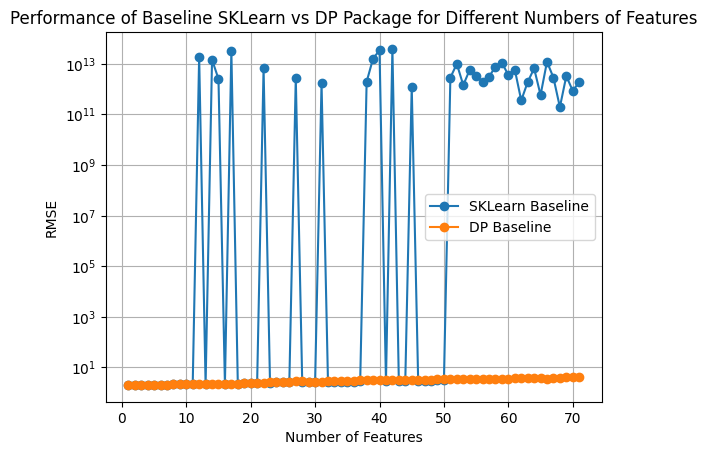

In [16]:
plt.plot(ks, sklearn_base_lr_errs, '-o', label="SKLearn Baseline")
plt.plot(ks, dp_base_lr_errs, '-o', label="DP Baseline")
plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.title("Performance of Baseline SKLearn vs DP Package for Different Numbers of Features")
plt.grid(axis="both")
plt.legend();

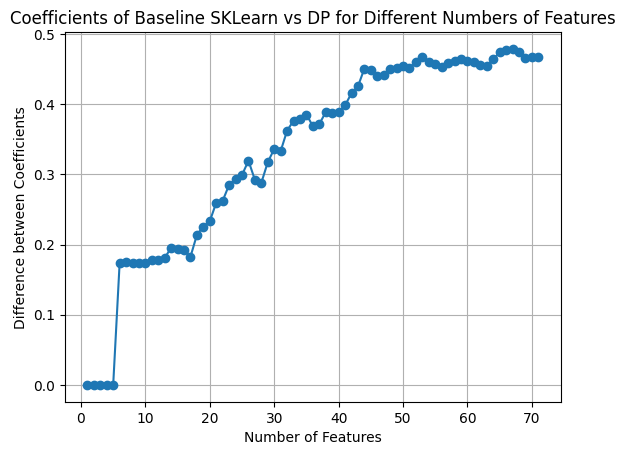

In [17]:
plt.plot(ks, base_coef_diffs, '-o')
plt.xlabel("Number of Features")
plt.ylabel("Difference between Coefficients")
plt.title("Coefficients of Baseline SKLearn vs DP for Different Numbers of Features")
plt.grid(axis="both");

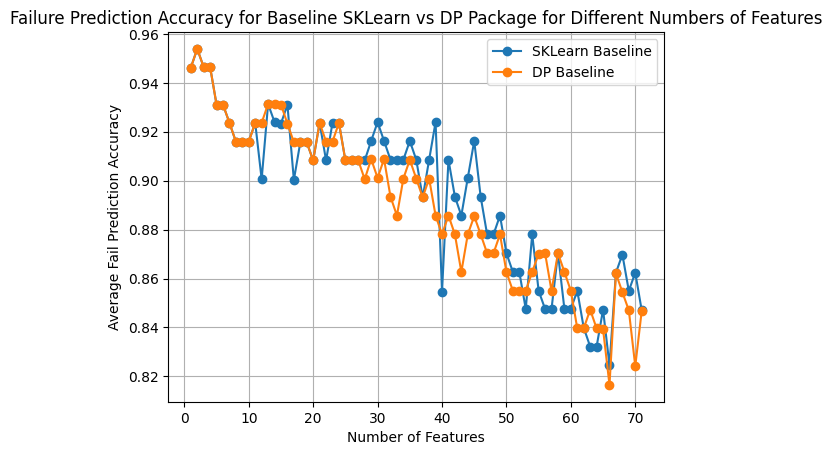

In [18]:
plt.plot(ks, sklearn_base_lr_fail_accs, '-o', label="SKLearn Baseline")
plt.plot(ks, dp_base_lr_fail_accs, '-o', label="DP Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Average Fail Prediction Accuracy")
plt.title("Failure Prediction Accuracy for Baseline SKLearn vs DP Package for Different Numbers of Features")
plt.grid(axis="both")
plt.legend();

## Linear Regression

### Basic Linear Regression Comparison using Top 2 Features

In [10]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'fail_pred_acc': getFailPredictionAccuracyScorer
}

X_train_top2, X_test_top2 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 2)

min_bounds_X = [-3 for _ in range(X_train_top2.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top2.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" Linear Regression model using DP version with infinite epsilon
base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,20)).fit(X_train_top2, y_train)  
base_lr_scores = cross_validate(base_lr, X_test_top2, y_test, cv=5, scoring=scoring)

# Get student fail prediction accuracy
base_lr_fail_acc = np.mean(base_lr_scores['test_fail_pred_acc'])
    
# Get RMSE
base_lr_err = np.mean(np.power(np.abs(base_lr_scores['test_MSE']), 0.5))

print("Baseline RMSE:", base_lr_err)
print("Baseline Fail Prediction Accuracy:", base_lr_fail_acc)

Baseline RMSE: 2.033449719023687
Baseline Fail Prediction Accuracy: 0.953846153846154


In [ ]:
epsilons = np.logspace(-2, 2, 300)
priv_lr_errors = []
priv_lr_fail_accuracies = []
lr_coef_distances = []

scoring = {
    'MSE': 'neg_mean_squared_error',
    'fail_pred_acc': getFailPredictionAccuracyScorer
}

for e in epsilons:
    priv_lr = dp_linreg(epsilon=e, bounds_X=bounds_X, bounds_y=(0,20), random_state=42). fit(X_train_top2, y_train)
    priv_lr_scores = cross_validate(priv_lr, X_test_top2, y_test, cv=5, scoring=scoring)

    # Get student fail prediction accuracy
    priv_lr_fail_accuracies.append(np.mean(priv_lr_scores['test_fail_pred_acc']))

    # Get RMSE
    priv_lr_errors.append(np.mean(np.power(np.abs(priv_lr_scores['test_MSE']), 0.5)))

    # Get Coefficient Distances
    lr_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))
    
print("Errors:", priv_lr_errors)
print("Coefficient Distances:", lr_coef_distances)
print("Fail Prediction Accuracies:", priv_lr_fail_accuracies)

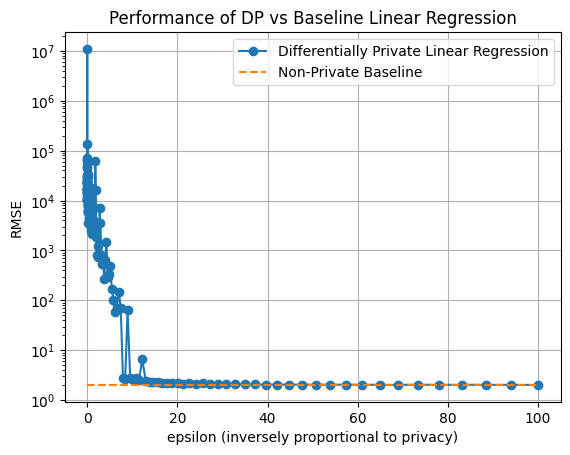

In [53]:
plt.plot(epsilons, priv_lr_errors, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_err * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("RMSE")
plt.title("Performance of DP vs Baseline Linear Regression")
plt.grid(axis="both")
plt.legend();

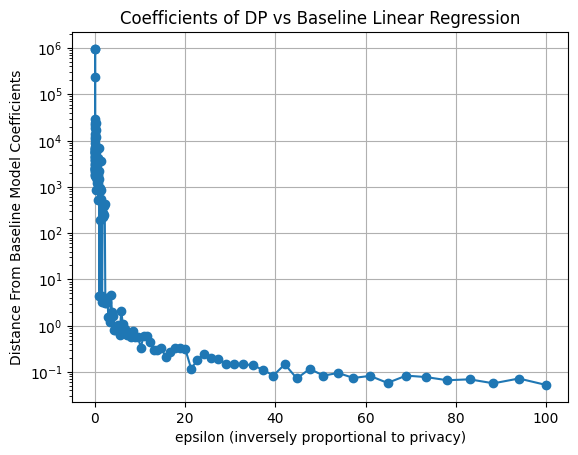

In [54]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.grid(axis="both")
plt.title("Coefficients of DP vs Baseline Linear Regression");

#### Assume that teachers are offering a tutoring program with limited capacity. They use these models to predict which students may have failing grades in the final grading period (<= 12/20) and offer them tutoring. Let's evaluate the accuracy of the baseline model vs the private model in this scenario.

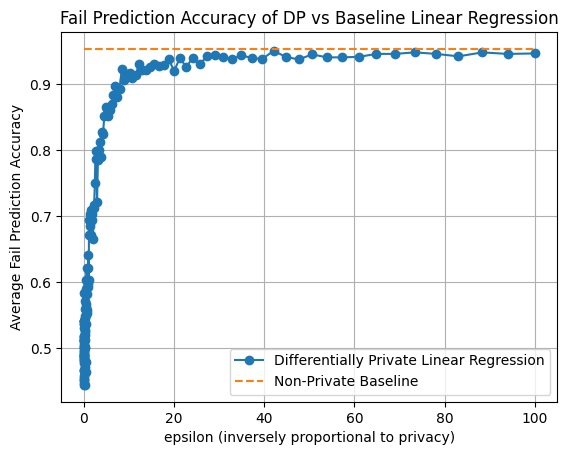

In [55]:
plt.plot(epsilons, priv_lr_fail_accuracies, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_fail_acc * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Average Fail Prediction Accuracy")
plt.title("Fail Prediction Accuracy of DP vs Baseline Linear Regression")
plt.grid(axis="both")
plt.legend();

### 2 Features, But Averaging Performance

In [37]:
# Define Fail Prediction Accuracy Scorer
def getFailPredictionAccuracy(y, y_pred):
    y = y["G3"].tolist()
    y_pred = y_pred.flatten()
    return np.mean([(y[i] <= 12 and y_pred[i] <= 12) or (y[i] > 12 and y_pred[i] > 12) for i in range(len(y))])

getFailPredictionAccuracyScorer = make_scorer(getFailPredictionAccuracy)

scoring = {
    'MSE': 'neg_mean_squared_error',
    'fail_pred_acc': getFailPredictionAccuracyScorer
}

X_train_top2, X_test_top2 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 2)

min_bounds_X = [-3 for _ in range(X_train_top2.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top2.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" Linear Regression model using DP version with infinite epsilon
base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,20)).fit(X_train_top2, y_train)  
base_lr_scores = cross_validate(base_lr, X_test_top2, y_test, cv=5, scoring=scoring)

# Get student fail prediction accuracy
base_lr_fail_acc = np.mean(base_lr_scores['test_fail_pred_acc'])
    
# Get RMSE
base_lr_err = np.mean(np.power(np.abs(base_lr_scores['test_MSE']), 0.5))

print("Baseline RMSE:", base_lr_err)
print("Baseline Fail Prediction Accuracy:", base_lr_fail_acc)

Baseline RMSE: 2.033449719023687
Baseline Fail Prediction Accuracy: 0.953846153846154


In [ ]:
epsilons = np.logspace(-2, 2, 150)
priv_lr_errors = []
priv_lr_fail_accuracies = []
lr_coef_distances = []

scoring = {
    'MSE': 'neg_mean_squared_error',
    'fail_pred_acc': getFailPredictionAccuracyScorer
}

# Define bounds for each of the features.

for e in epsilons:
    current_fail_accuracies = []
    current_errors = []
    current_coef_distances = []

    for i in range(10):
        priv_lr = dp_linreg(epsilon=e, bounds_X=bounds_X, bounds_y=(0,20)). fit(X_train_top2, y_train)
        priv_lr_scores = cross_validate(priv_lr, X_test_top2, y_test, cv=5, scoring=scoring)

        # Get student fail prediction accuracy
        current_fail_accuracies.append(np.mean(priv_lr_scores['test_fail_pred_acc']))

        # Get RMSE
        current_errors.append(np.mean(np.power(np.abs(priv_lr_scores['test_MSE']), 0.5)))

        # Get Coefficient Distances
        current_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))

    # Get average metrics across all 10 iterations
    priv_lr_fail_accuracies.append(np.mean(current_fail_accuracies))
    priv_lr_errors.append(np.mean(current_errors))
    lr_coef_distances.append(np.mean(current_coef_distances))
    
print("Errors:", priv_lr_errors)
print("Coefficient Distances:", lr_coef_distances)
print("Fail Prediction Accuracies:", priv_lr_fail_accuracies)

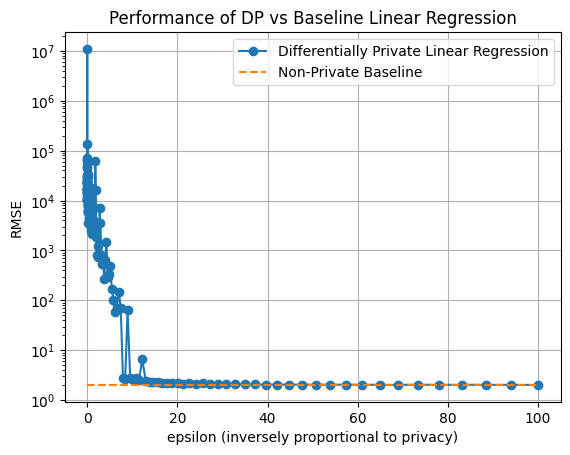

In [56]:
plt.plot(epsilons, priv_lr_errors, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_err * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("RMSE")
plt.title("Performance of DP vs Baseline Linear Regression")
plt.grid(axis="both")
plt.legend();

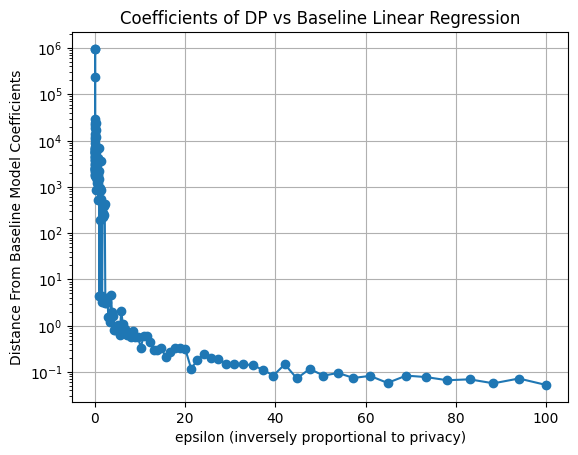

In [57]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.grid(axis="both")
plt.title("Coefficients of DP vs Baseline Linear Regression");

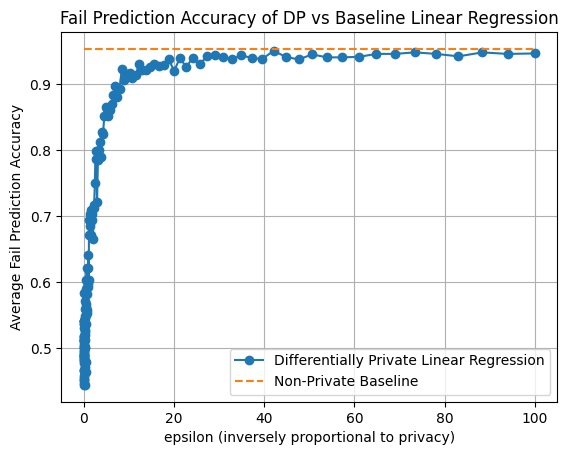

In [58]:
plt.plot(epsilons, priv_lr_fail_accuracies, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_fail_acc * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Average Fail Prediction Accuracy")
plt.title("Fail Prediction Accuracy of DP vs Baseline Linear Regression")
plt.grid(axis="both")
plt.legend();

### Trying for Different Numbers of Features

In [30]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'fail_pred_acc': getFailPredictionAccuracyScorer
}

ks = range(1, len(X_train.columns) + 1)
epsilons = [1, 5, 10]

base_lr_fail_accs = []
base_lr_errs = []

priv_lr_errors = [[] for _ in epsilons]
priv_lr_fail_accuracies = [[] for _ in epsilons]
lr_coef_distances = [[] for _ in epsilons]

for k in range(len(ks)):
    X_train_topk, X_test_topk = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, ks[k])

    min_bounds_X = [-3 for _ in range(k + 1)]
    max_bounds_X = [3 for _ in range(k + 1)]
    bounds_X = (min_bounds_X, max_bounds_X)

    # Create "baseline" Linear Regression model using DP version with infinite epsilon
    base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,20)).fit(X_train_topk, y_train)  
    # base_lr = sklearn_linreg().fit(X_train_topk, y_train)
    base_lr_scores = cross_validate(base_lr, X_test_topk, y_test, cv=5, scoring=scoring)

    # Get student fail prediction accuracy
    base_lr_fail_acc = np.mean(base_lr_scores['test_fail_pred_acc'])
    base_lr_fail_accs.append(base_lr_fail_acc)
    
    # Get RMSE
    base_lr_err = np.mean(np.power(np.abs(base_lr_scores['test_MSE']), 0.5))
    base_lr_errs.append(base_lr_err)

    for e in range(len(epsilons)):
        priv_lr = dp_linreg(epsilon=epsilons[e], bounds_X=bounds_X, bounds_y=(0,20), random_state=42). fit(X_train_topk, y_train)
        priv_lr_scores = cross_validate(priv_lr, X_test_topk, y_test, cv=5, scoring=scoring)
        
        # print(f"K: {k}, E: {e}, ")
        # Get student fail prediction accuracy
        priv_lr_fail_accuracies[e].append( np.mean(priv_lr_scores['test_fail_pred_acc']))

        # Get RMSE
        priv_lr_errors[e].append(np.mean(np.power(np.abs(priv_lr_scores['test_MSE']), 0.5)))

        # Get Coefficient Distances
        lr_coef_distances[e].append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))

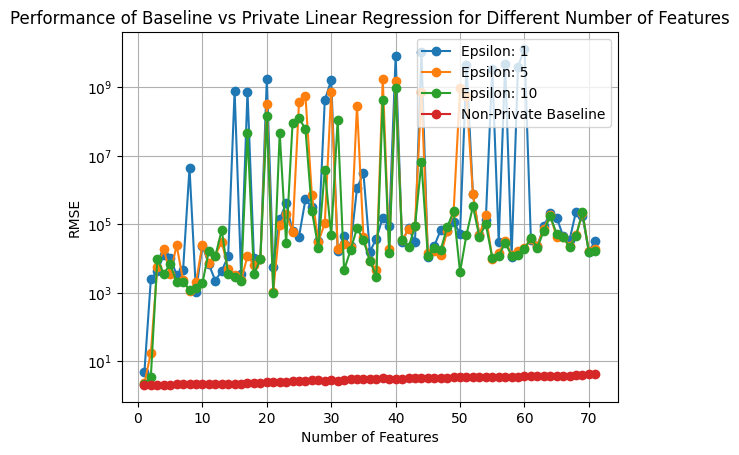

In [31]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_lr_errors[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_lr_errs * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.title("Performance of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

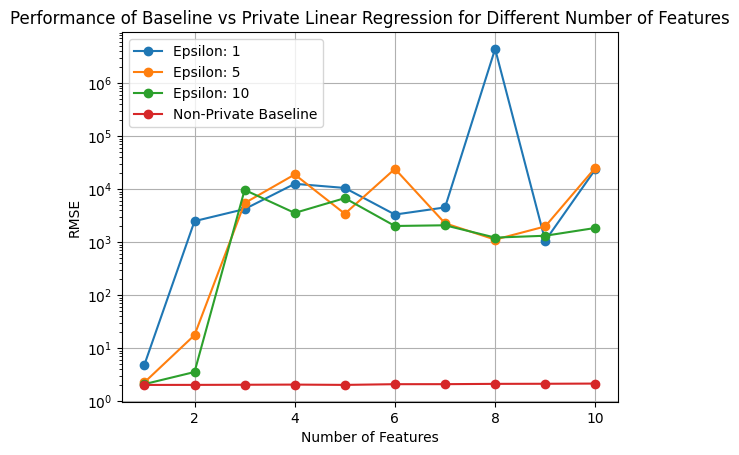

In [32]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], priv_lr_errors[e][:10], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks[:10], base_lr_errs[:10] * np.ones(10), '-o', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.title("Performance of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

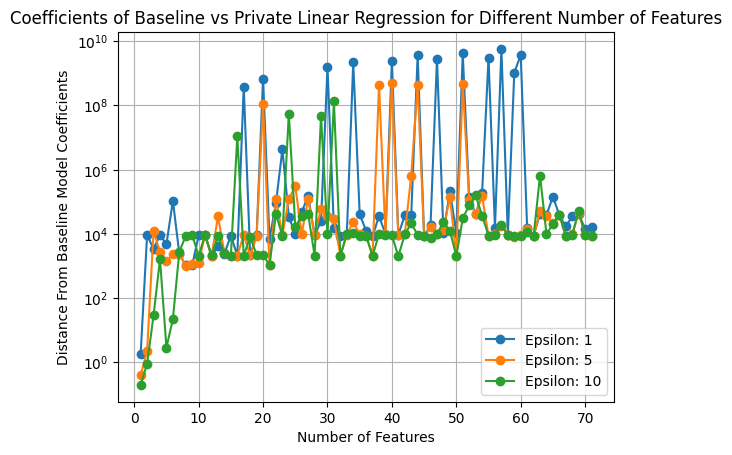

In [33]:
for e in range(len(epsilons)):
    plt.plot(ks, lr_coef_distances[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.title("Coefficients of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

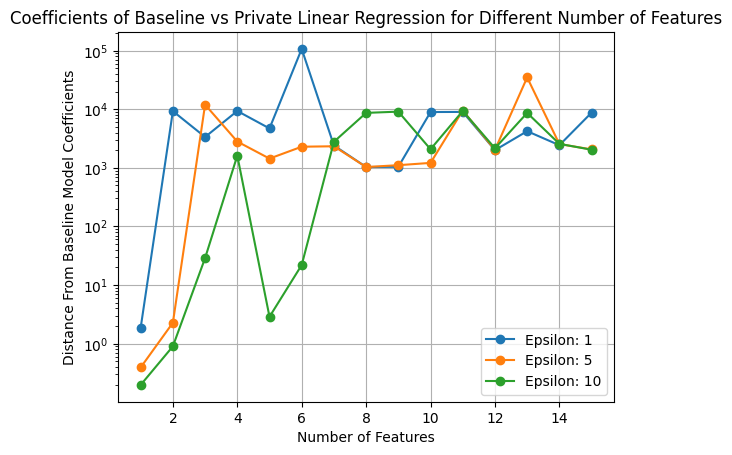

In [34]:
for e in range(len(epsilons)):
    plt.plot(ks[:15], lr_coef_distances[e][:15], '-o', label=f"Epsilon: {epsilons[e]}")

plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.title("Coefficients of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

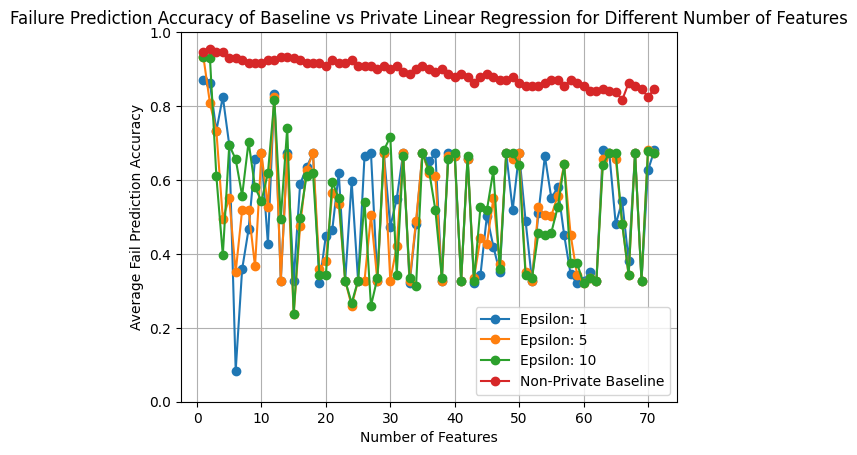

In [35]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_lr_fail_accuracies[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_lr_fail_accs * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Average Fail Prediction Accuracy")
plt.ylim(0, 1)
plt.title("Failure Prediction Accuracy of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

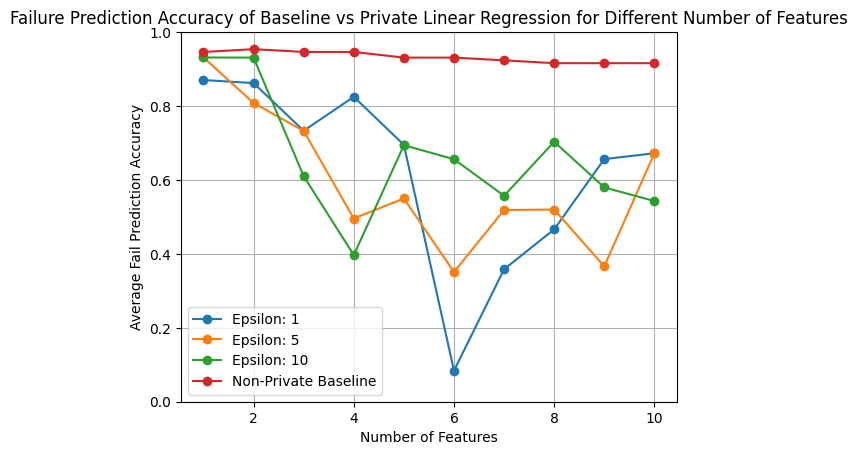

In [36]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], priv_lr_fail_accuracies[e][:10], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks[:10], base_lr_fail_accs[:10] * np.ones_like(ks[:10]), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Average Fail Prediction Accuracy")
plt.ylim(0, 1)
plt.title("Failure Prediction Accuracy of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();